In [1]:
import numpy as np
import pandas as pd
from detection import FileProcessor, SubjectData
from utils import train_subjects, test_subjects
import h5py
import matplotlib.pyplot as plt

In [7]:
# Generate train data
train_data = {
    'green': [],
    'blinking': [],
    'feedback': []
}

names = ['green', 'blinking', 'feedback']

for subject in train_subjects:
    for i in range(1, 6):
        file_path = f'data/train/Data_S{subject}_Sess0{i}.csv'
        fp = FileProcessor(file_path)
        fdata = fp.get_segments_for_rnn()
        for name in names:
            for matrix in fdata[name]:
                train_data[name].append(matrix)
        print(f"Finished processiong subject {subject} session {i}!")

# Check segment consistency
assert len(train_data[names[0]]) == len(train_data[names[1]]) == len(train_data[names[2]]), "Mismatched trial counts!"

with h5py.File('./cache/rnn_data/eeg_train_data.h5', 'w') as f:
    for key in names:
        # Create datasets with variable-length second dimension (shape is (n_channels, n_samples) where n_samples is variable)
        f.create_group(key)
        for i, arr in enumerate(train_data[key]):
            f[key].create_dataset(str(i), data=arr)

Finished processiong subject 02 session 1!
Finished processiong subject 02 session 2!
Finished processiong subject 02 session 3!
Finished processiong subject 02 session 4!
Finished processiong subject 02 session 5!
Finished processiong subject 06 session 1!
Finished processiong subject 06 session 2!
Finished processiong subject 06 session 3!
Finished processiong subject 06 session 4!
Finished processiong subject 06 session 5!
Finished processiong subject 07 session 1!
Finished processiong subject 07 session 2!
Finished processiong subject 07 session 3!
Finished processiong subject 07 session 4!
Finished processiong subject 07 session 5!
Finished processiong subject 11 session 1!
Finished processiong subject 11 session 2!
Finished processiong subject 11 session 3!
Finished processiong subject 11 session 4!
Finished processiong subject 11 session 5!
Finished processiong subject 12 session 1!
Finished processiong subject 12 session 2!
Finished processiong subject 12 session 3!
Finished pr

In [8]:
# Generate test data
test_data = {
    'green': [],
    'blinking': [],
    'feedback': []
}

names = ['green', 'blinking', 'feedback']

for subject in test_subjects:
    for i in range(1, 6):
        file_path = f'data/test/Data_S{subject}_Sess0{i}.csv'
        fp = FileProcessor(file_path)
        fdata = fp.get_segments_for_rnn()
        for name in names:
            for matrix in fdata[name]:
                test_data[name].append(matrix)
        print(f"Finished processiong subject {subject} session {i}!")

# Check segment consistency
assert len(test_data[names[0]]) == len(test_data[names[1]]) == len(test_data[names[2]]), "Mismatched trial counts!"

with h5py.File('./cache/rnn_data/eeg_test_data.h5', 'w') as f:
    for key in names:
        # Create datasets with variable-length second dimension (shape is (n_channels, n_samples) where n_samples is variable)
        f.create_group(key)
        for i, arr in enumerate(test_data[key]):
            f[key].create_dataset(str(i), data=arr)

Finished processiong subject 01 session 1!
Finished processiong subject 01 session 2!
Finished processiong subject 01 session 3!
Finished processiong subject 01 session 4!
Finished processiong subject 01 session 5!
Finished processiong subject 03 session 1!
Finished processiong subject 03 session 2!
Finished processiong subject 03 session 3!
Finished processiong subject 03 session 4!
Finished processiong subject 03 session 5!
Finished processiong subject 04 session 1!
Finished processiong subject 04 session 2!
Finished processiong subject 04 session 3!
Finished processiong subject 04 session 4!
Finished processiong subject 04 session 5!
Finished processiong subject 05 session 1!
Finished processiong subject 05 session 2!
Finished processiong subject 05 session 3!
Finished processiong subject 05 session 4!
Finished processiong subject 05 session 5!
Finished processiong subject 08 session 1!
Finished processiong subject 08 session 2!
Finished processiong subject 08 session 3!
Finished pr

In [2]:
rnn_pred = pd.read_csv("./submissions/try6_NickNet.csv")['Prediction'].to_numpy()
sgd_pred = pd.read_csv("./submissions/sgd_smote_final1.csv")['Prediction'].to_numpy()
print(rnn_pred.shape, sgd_pred.shape)

(3400,) (3400,)


In [3]:
rnn_w = 0.5005
sgd_w = 0.4995
ensemble_pred = rnn_w*rnn_pred + sgd_w*sgd_pred
print(ensemble_pred.shape)

(3400,)


In [4]:
ids = []
for i in range(len(test_subjects)):
    name = f'S{test_subjects[i]}'
    for session in range(1, 5):
        for fid in range(1, 61):
            ids.append(f'{name}_Sess{session:02}_FB{fid:03}')
    for fid in range(1, 101):
        ids.append(f'{name}_Sess05_FB{fid:03}')
ids = np.array(ids)
print(f'ids: {ids.shape}')
print(ids)

result = pd.DataFrame({
    'IdFeedback': ids,
    'Prediction': ensemble_pred
})

result.to_csv("./submissions/ensemble1.csv", sep=',', index=False)

ids: (3400,)
['S01_Sess01_FB001' 'S01_Sess01_FB002' 'S01_Sess01_FB003' ...
 'S25_Sess05_FB098' 'S25_Sess05_FB099' 'S25_Sess05_FB100']


In [21]:
def h5tonpy(input_file):
    with h5py.File(input_file) as f:
        green = f['green'] 
        feedback = f['feedback']
        green_arr = []
        fb_arr = []
        for i in range(len(green)):
            part = np.array(green[str(i)])
            #print(type(part), part.shape)
            green_arr.append(part)
        green_arr = np.array(green_arr)
        #print(green_arr.shape)
        #np.save('./cache/rnn_data/green_train.npy', green_arr)
        for i in range(len(feedback)):
            part = np.squeeze(np.array(feedback[str(i)]), axis=0)
            #print(part.shape)
            fb_arr.append(part)
        n_min = min(arr.shape[1] for arr in fb_arr)
        truncated_arrays = [arr[:, :n_min] for arr in fb_arr]
        fb_arr = np.array(truncated_arrays)
        #print(fb_arr.shape)
        #np.save('./cache/rnn_data/feedback_train.npy', fb_arr)
        return green_arr, fb_arr

tr1, tr2 = h5tonpy('./cache/rnn_data/eeg_train_data.h5')
print(tr1.shape, tr2.shape)
np.save('./cache/rnn_data/green_train.npy', tr1)
np.save('./cache/rnn_data/feedback_train.npy', tr2)

te1, te2 = h5tonpy('./cache/rnn_data/eeg_test_data.h5')
print(te1.shape, te2.shape)
np.save('./cache/rnn_data/green_test.npy', te1)
np.save('./cache/rnn_data/feedback_test.npy', te2)


(5440, 16, 220) (5440, 16, 260)
(3400, 16, 220) (3400, 16, 260)


(260,)


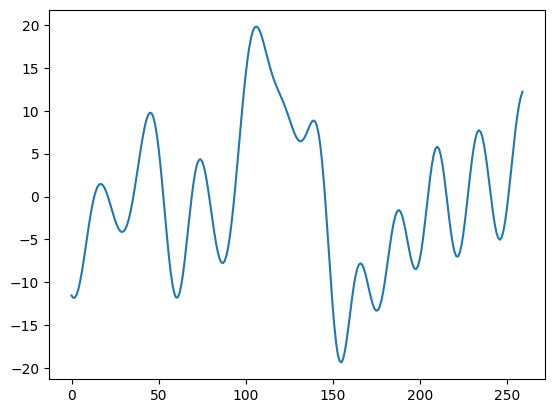

In [6]:
test = np.load('./cache/rnn_data/feedback_test.npy')
x = test[0, 0]
print(x.shape)
plt.plot(x)

In [2]:
temp = np.load("./cache/rnn_data/handcrafted_features_train.npy")
print(temp.shape)

(5440, 28)


In [2]:
features = []
for i in range(len(train_subjects)):
    sd = SubjectData(train_subjects[i], train=True)
    features.append(sd.get_similarity_expanded())

In [ ]:
features = np.array(features)
print(features.shape)

(16, 340, 16, 24)


In [4]:
features = np.concatenate(features, axis=0)
print(features.shape)

(5440, 16, 24)


In [5]:
np.save("./cache/rnn_data/sim_train.npy", features)